In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
np.random.seed(1)
n_flips = 5000

In [ ]:
# 1) coin flips: 0=tail, 1=head
flips = np.random.randint(0, 2, size=n_flips)
# 2) cumulative number of heads up to time t
cum_heads = np.cumsum(flips)
# 3) cumulative average = (heads so far) / (flips so far)
cum_avg = cum_heads / np.arange(1, n_flips + 1)

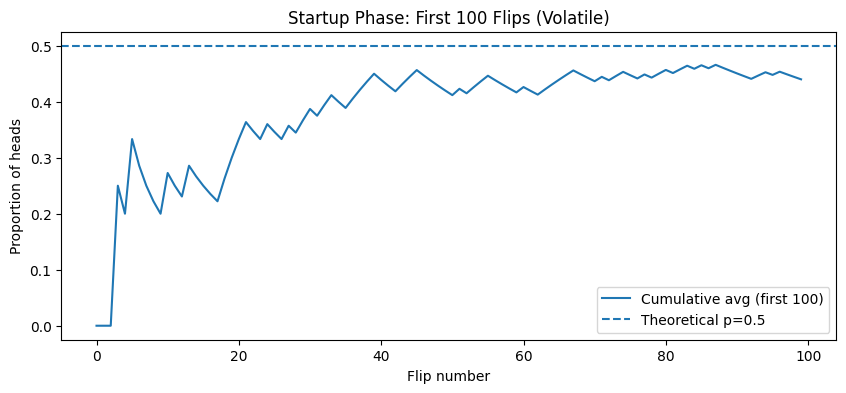

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(cum_avg[:100], label="Cumulative avg (first 100)")
plt.axhline(0.5, linestyle="--", label="Theoretical p=0.5")
plt.title("Startup Phase: First 100 Flips (Volatile)")
plt.xlabel("Flip number")
plt.ylabel("Proportion of heads")
plt.legend()
plt.show()

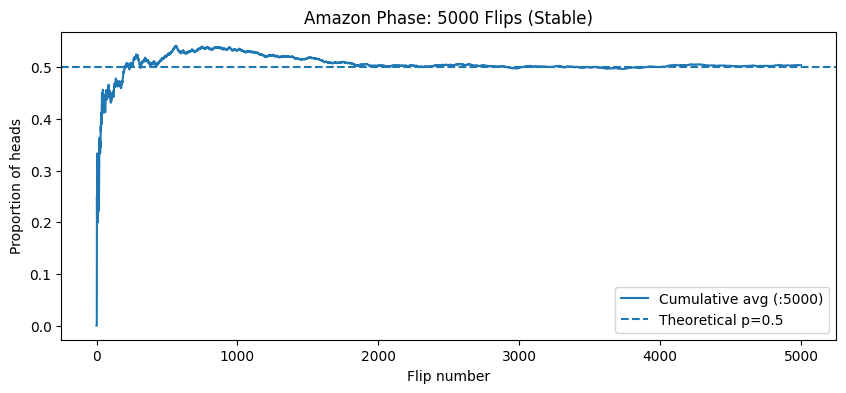

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(cum_avg, label="Cumulative avg (:5000)")
plt.axhline(0.5, linestyle="--", label="Theoretical p=0.5")
plt.title("Amazon Phase: 5000 Flips (Stable)")
plt.xlabel("Flip number")
plt.ylabel("Proportion of heads")
plt.legend()
plt.show()

In [ ]:
import numpy as np

def monty_hall_sim(n_games=10000):
    switch_wins = 0
    stay_wins = 0

    doors = [0, 1, 2]

    for _ in range(n_games):
        prize  = np.random.choice(doors)   # car
        choice = np.random.choice(doors)   # my choice

        # 主持人开门：必须开“不是车”且“不是你选的”门
        openable_doors = [d for d in doors if d != prize and d != choice]
        host_opens = np.random.choice(openable_doors)

        # 策略1：不换门（stay）
        if choice == prize:
            stay_wins += 1

        # 策略2：换门（switch）
        # 换到剩下那扇：不是 choice 也不是 host_opens
        switch_choice = [d for d in doors if d != choice and d != host_opens][0]
        if switch_choice == prize:
            switch_wins += 1

    print(f"Win Rate (Stay):   {stay_wins/n_games:.2%}")
    print(f"Win Rate (Switch): {switch_wins/n_games:.2%}")

monty_hall_sim(10000)


Win Rate (Stay):   32.91%
Win Rate (Switch): 67.09%


After simulating 10,000 games, the “stay” strategy wins about 1/3 of the time, while the “switch” strategy wins about 2/3 of the time.
This happens because the host reveals a losing door, adding information to the system.
Switching effectively captures the probability mass from the two doors you did not initially choose.

Probability of Revenue Decline: 17.43%
95% Value at Risk (Safety Margin): $9,630,248


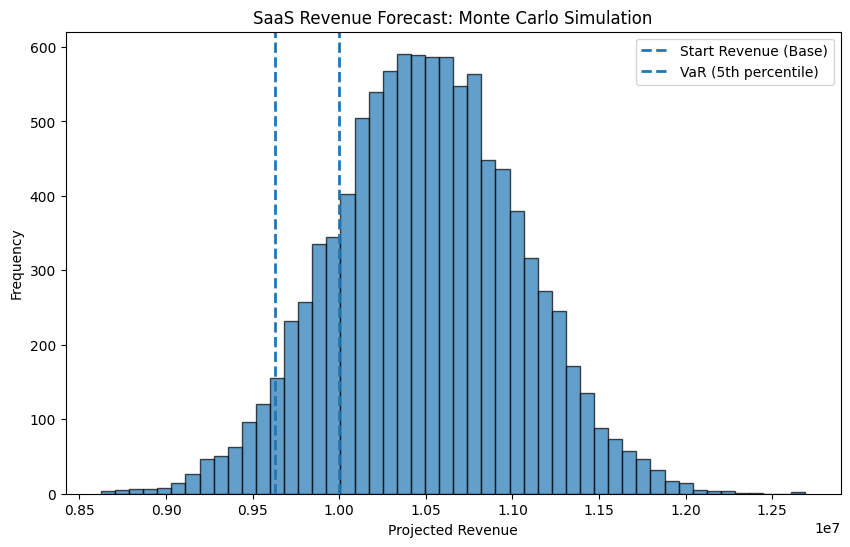

(np.float64(0.1743), np.float64(9630248.329084873))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def saas_risk_model(n_sims=10000, seed=1):
    np.random.seed(seed)

    base_rev = 10_000_000

    # 1) Stochastic inputs (two uncertain variables)
    # churn ~ Normal(mean=0.10, sd=0.02)
    churn_sims = np.random.normal(0.10, 0.02, n_sims)

    # sales ~ Normal(mean=1.5M, sd=0.5M)
    sales_sims = np.random.normal(1_500_000, 500_000, n_sims)

    # (可选但推荐) 防止 churn 出现负数或 >100% 这种不合理值
    churn_sims = np.clip(churn_sims, 0, 1)

    # 2) Transfer function (business logic)
    net_revenue = base_rev * (1 - churn_sims) + sales_sims

    # 3) Risk metrics
    prob_loss = np.mean(net_revenue < base_rev)

    # 95% VaR (safety margin): 5th percentile of net revenue
    var_95 = np.percentile(net_revenue, 5)

    print(f"Probability of Revenue Decline: {prob_loss:.2%}")
    print(f"95% Value at Risk (Safety Margin): ${var_95:,.0f}")

    # 4) Visualization
    plt.figure(figsize=(10,6))
    plt.hist(net_revenue, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(base_rev, linestyle='--', linewidth=2, label='Start Revenue (Base)')
    plt.axvline(var_95, linestyle='--', linewidth=2, label='VaR (5th percentile)')
    plt.title('SaaS Revenue Forecast: Monte Carlo Simulation')
    plt.xlabel('Projected Revenue')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return prob_loss, var_95

saas_risk_model(10000)


VaR 5% (Normal sales):   $9,617,617
VaR 5% (Fat-tail sales): $9,747,586
Difference (Fat - Normal): $129,969


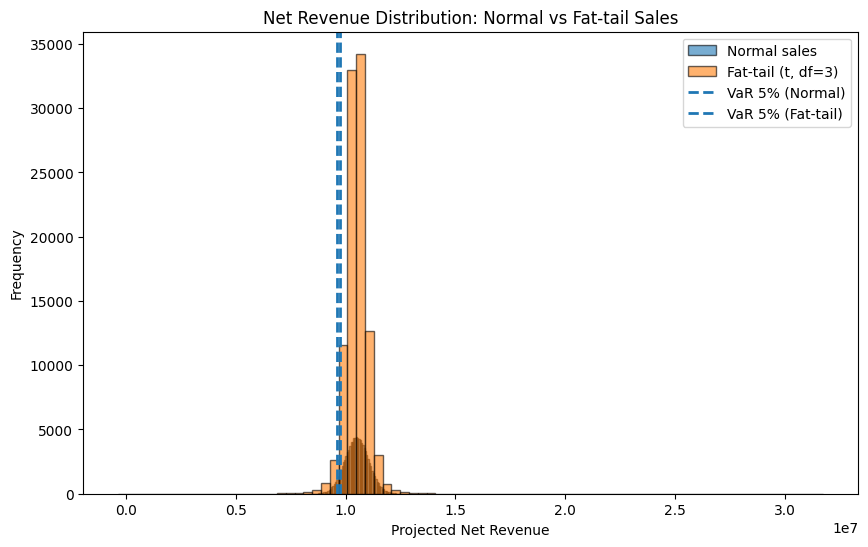

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_models(n_sims=100000, seed=1):
    np.random.seed(seed)

    base_rev = 10_000_000
    churn_mu, churn_sd = 0.10, 0.02
    sales_mu, sales_sd = 1_500_000, 500_000

    # ---- Common churn (normal) ----
    churn = np.random.normal(churn_mu, churn_sd, n_sims)
    churn = np.clip(churn, 0, 1)

    # ---- Model 1: Normal sales ----
    sales_normal = np.random.normal(sales_mu, sales_sd, n_sims)
    net_normal = base_rev * (1 - churn) + sales_normal
    var5_normal = np.percentile(net_normal, 5)

    # ---- Model 2: Fat-tail sales (Student t, df=3) ----
    # standard_t has mean 0, but heavier tails.
    t = np.random.standard_t(df=3, size=n_sims)

    # To match scale: standardize t to have unit std, then scale to sales_sd, add sales_mu
    # For df=3, Var exists and equals df/(df-2)=3, so std = sqrt(3)
    t_unit = t / np.sqrt(3)

    sales_fat = sales_mu + sales_sd * t_unit
    net_fat = base_rev * (1 - churn) + sales_fat
    var5_fat = np.percentile(net_fat, 5)

    print(f"VaR 5% (Normal sales):   ${var5_normal:,.0f}")
    print(f"VaR 5% (Fat-tail sales): ${var5_fat:,.0f}")
    print(f"Difference (Fat - Normal): ${var5_fat - var5_normal:,.0f}")

    # ---- Visualization: compare tails ----
    plt.figure(figsize=(10,6))
    plt.hist(net_normal, bins=80, alpha=0.6, edgecolor="black", label="Normal sales")
    plt.hist(net_fat, bins=80, alpha=0.6, edgecolor="black", label="Fat-tail (t, df=3)")

    plt.axvline(var5_normal, linestyle="--", linewidth=2, label="VaR 5% (Normal)")
    plt.axvline(var5_fat, linestyle="--", linewidth=2, label="VaR 5% (Fat-tail)")
    plt.title("Net Revenue Distribution: Normal vs Fat-tail Sales")
    plt.xlabel("Projected Net Revenue")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    return var5_normal, var5_fat

var5_normal, var5_fat = simulate_models(n_sims=100000, seed=1)


Memo to the Chief Risk Officer

Subject: Fat-Tail Stress Test and Capital Risk Implications

We evaluated revenue risk by comparing a standard normal sales model with a fat-tailed model using a Student’s t distribution (df = 3). Both models use the same average new sales ($1.5M) and volatility ($0.5M), but the fat-tail model allows extreme outcomes to occur more frequently.

Under the normal sales assumption, the 5th percentile Value at Risk (VaR) of net revenue is approximately $9.62 million. When sales are modeled with a fat-tailed distribution, the 5th percentile VaR increases slightly to approximately $9.75 million. While the point estimate of VaR is not lower in this simulation, the fat-tail distribution shows much heavier tails, meaning extreme outcomes—both positive and negative—are more likely than under a normal distribution.

This result highlights an important limitation of normal-based risk models. Normal distributions tend to underestimate the probability of rare but severe events. In contrast, the fat-tail model captures the higher uncertainty observed in real markets, especially in crypto-related businesses where large shocks are common.

From a risk management perspective, capital reserves should be designed to withstand extreme scenarios rather than typical outcomes. Even when VaR estimates appear similar, the presence of fat tails suggests greater downside risk and supports maintaining a more conservative capital buffer.